In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization, SeparableConv2D, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
base_model1 = InceptionV3(include_top=False , input_shape=(3, 150, 150))

87916544/87910968 [==============================] - 10s 0us/step


In [3]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="transferlearning_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [4]:
x = base_model1.output
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [5]:
base_model1.load_weights("C:\\Users\\kyrie\\.keras\\models\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [6]:
t_model = Model(inputs=base_model1.input, outputs=predictions)

In [7]:
t_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [8]:
t_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 150, 150) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 74, 74)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 74, 74)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
with open('X_train.pkl', 'rb') as file:
    X_train =pickle.load(file)
with open('X_test.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_train.pkl', 'rb') as file:
    y_train =pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test =pickle.load(file)
with open('X_val.pkl', 'rb') as file:
    X_val =pickle.load(file)
    
with open('y_val.pkl', 'rb') as file:
    y_val =pickle.load(file)

In [10]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)
X_val = X_val.reshape(16,3,150,150)

In [11]:
history = t_model.fit(X_train, y_train, validation_data = (X_val , y_val) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=7)

Train on 5216 samples, validate on 16 samples
Epoch 1/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9221
Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to transferlearning_weights2.hdf5
5216/5216 [==============================] - 81s 16ms/sample - loss: 0.2005 - accuracy: 0.9224 - val_loss: 0.2462 - val_accuracy: 0.8750
Epoch 2/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9599
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_accuracy did not improve from 0.87500
5216/5216 [==============================] - 25s 5ms/sample - loss: 0.1112 - accuracy: 0.9599 - val_loss: 1.1779 - val_accuracy: 0.7500
Epoch 3/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9732
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_accuracy did not improve from 0.87500
5216/5216 [=

In [12]:
t_model.load_weights('transferlearning_weights2.hdf5')

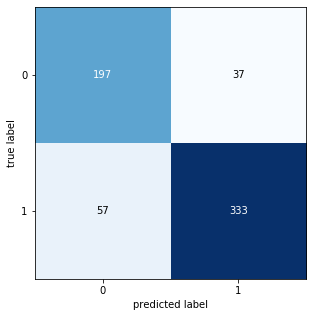

In [13]:
pred = t_model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_test = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

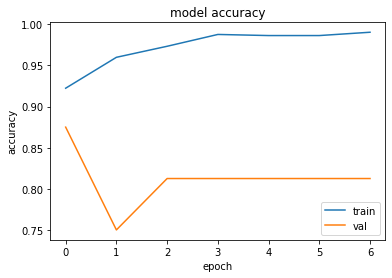

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

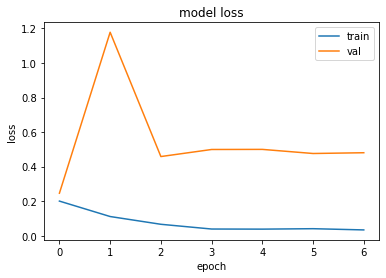

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [16]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       234
           1       0.90      0.85      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.85      0.85      0.85       624

